# Markov Chain Monte Carlo

A Markov chain is a sequence of random variables where a given value nontrivially depends only on its preceding value. That is, given the present value, past and future values are independent. In this sense, a Markov chain is “memoryless.” The process generating such a chain is called the Markov process and can be described as

$$p(\theta_{i+1} | \{\theta_i\}) = p(\theta_{i +1} | \theta_{i} )$$,

that is, the next value depends only on the current value.

In our context, $\theta$ can be thought of as a vector in multidimensional space, and a
realization of the chain represents a path through this space. To reach an equilibrium,
or stationary, distribution of positions, it is necessary that the **transition probability** is symmetric (for eq Chapman Kolmogorov & SDEs and more details see http://fab.cba.mit.edu/classes/864.20/text/random.pdf):

$$p(\theta_{i+1}|\theta_i) = p(\theta_i|\theta_{i+1})$$

This condition is called the detailed balance or reversibility condition. It shows that the probability of a jump between two points does not depend on the direction of the jump.
There are various algorithms for producing Markov chains that reach some prescribed equilibrium distribution, $p(\theta)$. The use of resulting chains to perform Monte Carlo integration of

$$I(\theta)=\int g(\theta)p(\theta)d\theta$$

 is called Markov chain Monte Carlo (MCMC).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [log_gamma, mu]


Sampling 2 chains for 1_000 tune and 12_000 draw iterations (2_000 + 24_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.7027631222892872, but should be close to 0.8. Try to increase the number of tuning steps.


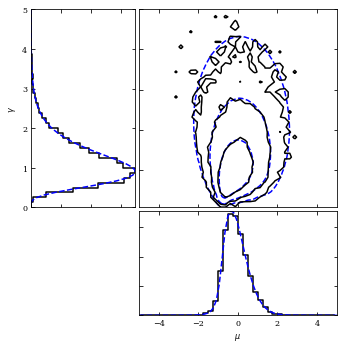

In [ ]:
"""
MCMC for the Cauchy distribution
--------------------------------
Figure 5.22
Markov chain monte carlo (MCMC) estimates of the posterior pdf for parameters
describing the Cauchy distribution. The data are the same as those used in
figure 5.10: the dashed curves in the top-right panel show the results of
direct computation on a regular grid from that diagram. The solid curves are
the corresponding MCMC estimates using 10,000 sample points. The left and the
bottom panels show marginalized distributions.
"""
# Author: Jake VanderPlas (adapted to PyMC3 by Brigitta Sipocz)
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from scipy.stats import cauchy
from matplotlib import pyplot as plt
from astroML.plotting.mcmc import convert_to_stdev

import pymc3 as pm

# ----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)


def cauchy_logL(xi, sigma, mu):
    """Equation 5.74: cauchy likelihood"""
    xi = np.asarray(xi)
    n = xi.size
    shape = np.broadcast(sigma, mu).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    return ((n - 1) * np.log(sigma)
            - np.sum(np.log(sigma ** 2 + (xi - mu) ** 2), 0))


# ----------------------------------------------------------------------
# Draw the sample from a Cauchy distribution
np.random.seed(44)
mu_0 = 0
gamma_0 = 2
xi = cauchy(mu_0, gamma_0).rvs(10)

# ----------------------------------------------------------------------
# Set up and run MCMC:
with pm.Model():
    mu = pm.Uniform('mu', -5, 5)
    log_gamma = pm.Uniform('log_gamma', -10, 10)

    # set up our observed variable x
    x = pm.Cauchy('x', mu, np.exp(log_gamma), observed=xi)

    trace = pm.sample(draws=12000, tune=1000, cores=1)

# compute histogram of results to plot below
L_MCMC, mu_bins, gamma_bins = np.histogram2d(trace['mu'],
                                             np.exp(trace['log_gamma']),
                                             bins=(np.linspace(-5, 5, 41),
                                                   np.linspace(0, 5, 41)))
L_MCMC[L_MCMC == 0] = 1E-16  # prevents zero-division errors

# ----------------------------------------------------------------------
# Compute likelihood analytically for comparison
mu = np.linspace(-5, 5, 70)
gamma = np.linspace(0.1, 5, 70)
logL = cauchy_logL(xi, gamma[:, np.newaxis], mu)
logL -= logL.max()

p_mu = np.exp(logL).sum(0)
p_mu /= p_mu.sum() * (mu[1] - mu[0])

p_gamma = np.exp(logL).sum(1)
p_gamma /= p_gamma.sum() * (gamma[1] - gamma[0])

hist_mu, bins_mu = np.histogram(trace['mu'], bins=mu_bins, density=True)
hist_gamma, bins_gamma = np.histogram(np.exp(trace['log_gamma']),
                                      bins=gamma_bins, density=True)


# ----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(5, 5))

# first axis: likelihood contours
ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.yaxis.set_major_formatter(plt.NullFormatter())

ax1.contour(mu, gamma, convert_to_stdev(logL),
            levels=(0.683, 0.955, 0.997),
            colors='b', linestyles='dashed')

ax1.contour(0.5 * (mu_bins[:-1] + mu_bins[1:]),
            0.5 * (gamma_bins[:-1] + gamma_bins[1:]),
            convert_to_stdev(np.log(L_MCMC.T)),
            levels=(0.683, 0.955, 0.997),
            colors='k')

# second axis: marginalized over mu
ax2 = fig.add_axes((0.1, 0.4, 0.29, 0.55))
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.plot(hist_gamma, 0.5 * (bins_gamma[1:] + bins_gamma[:-1]
                            - bins_gamma[1] + bins_gamma[0]),
         '-k', drawstyle='steps')
ax2.plot(p_gamma, gamma, '--b')
ax2.set_ylabel(r'$\gamma$')
ax2.set_ylim(0, 5)

# third axis: marginalized over gamma
ax3 = fig.add_axes((0.4, 0.1, 0.55, 0.29))
ax3.yaxis.set_major_formatter(plt.NullFormatter())
ax3.plot(0.5 * (bins_mu[1:] + bins_mu[:-1]), hist_mu,
         '-k', drawstyle='steps-mid')
ax3.plot(mu, p_mu, '--b')
ax3.set_xlabel(r'$\mu$')
plt.xlim(-5, 5)

plt.show()

# MCMC Algorithms
Algorithms for generating Markov chains are numerous and greatly vary in complexity and applicability. Many of the most important ideas were generated in physics, especially in the context of statistical mechanics, thermodynamics, and quantum field
theory. We will only discuss in detail the most famous Metropolis–Hastings
algorithm, and refer the reader to XXX, and references therein, for a detailed discussion of other algorithms.

In order for a Markov chain to reach a stationary distribution proportional to
$p(\theta)$, the probability of arriving at a point $\theta_{i+1}$ must be proportional to $p(\theta_{i+1})$,

$$p(\theta_{i+1})=\int T(\theta_{\theta_{i+1}|\theta_{i}})p(\theta_i)d\theta_i$$

where the transition probability $T(\theta_{i+1} | \theta_i)$ is called the jump kernel or transition kernel (and it is assumed that we know how to compute $p(\theta_i)$). This requirement will be satisfied when the transition probability satisfies the detailed balance condition

$$T(\theta_{i+1}|\theta_i)p(\theta_i)=T(\theta_i|\theta_{i+1})p(\theta_{i+1})$$

Various MCMC algorithms differ in their choice of transition kernel (see https://doc.lagout.org/science/0_Computer%20Science/3_Theory/Mathematics/Bayesian%20Logical%20Data%20Analysis%20for%20the%20Physical%20Sciences_%20A%20Comparative%20Approach%20with%20Mathematica%20Support%20%5BGregory%202010-06-28%5D.pdf for
a detailed discussion).


**The Metropolis–Hastings algorithm** adopts the kernel:

$$T(\theta_{i+1}|\theta_i)=p_{acc}(\theta_i, \theta_{i+1})K(\theta_{i+1}|\theta_i)$$

where the proposed density distribution $K(\theta_{i+1} | \theta_i, )$ is an arbitrary function. The proposed point $\theta_{i+1}$ is randomly accepted with the acceptance probability

$$p_{acc}=\frac{K(\theta_i|\theta_{i+1})p(\theta_{i+1})}{K(\theta_{i+1}|\theta_i)p(\theta_{i})}$$

(when exceeding 1, the proposed point $\theta_{i +1}$ is always accepted). When $\theta_{i+1}$ is
rejected, $\theta_{i}$ is added to the chain instead. A Gaussian distribution centered on $\theta_i$ is often used for $K(\theta_{i+1}| \theta_i)$.

The original Metropolis algorithm is based on a symmetric proposal distribution, $K(\theta_{i+1} |\theta_i) = K(\theta_i | \theta_{i+1})$, which then cancels out from the acceptance probability. In this case, $θ_{i+1}$ is always accepted if $p(\theta_{i+1}) > p(\theta_i)$, and if not, then it is accepted with a probability $p(\theta_{i+1})/ p(\theta_i)$.

Although $K(\theta_{i+1} | \theta_i)$ satisfies a Markov chain requirement that it must be a
function of only the current position $\theta_i$ , it takes a number of steps to reach a stationary distribution from an initial arbitrary position $\theta_0$ . These early steps are called the “burn-in” and need to be discarded in analysis. There is no general theory
for finding transition from the burn-in phase to the stationary phase; several methods
are used in practice. Gelman and Rubin proposed to generate a number of chains
and then compare the ratio of the variance between the chains to the mean variance
within the chains (this ratio is known as the R statistic). For stationary chains,
this ratio will be close to 1.

When the posterior pdf is multimodal, the simple Metropolis–Hastings algo-
rithm can become stuck in a local mode and not find the globally best mode within
a reasonable running time. There are a number of better algorithms, such as Gibbs
sampling, parallel tempering, various genetic algorithms, and nested sampling. (See http://fab.cba.mit.edu/classes/864.20/text/search.pdf, https://arxiv.org/abs/1701.02434 and https://arxiv.org/pdf/1310.7034.pdf) for PSO algorithm.


# PyMC: MCMC in Python
 PyMC (https://docs.pymc.io/ and https://peerj.com/articles/cs-55/) comprises a set of flexible tools for performing MCMC using the Metropolis–Hastings algorithm, as well as maximum a priori estimates, normal approximations, and other sampling techniques. It includes built-in models for common distributions and priors (e.g. Gaussian distribution, Cauchy distribution, etc.) as well as an easy framework to define arbitrarily complicated distributions.

While PyMC offers some powerful tools for fine-tuning of MCMC chains, such as varying step methods, fitting algorithms, and convergence diagnostics, for simplicity we use only the basic features for the examples here. In particular, the burn-in for each chain is accomplished by simply setting the burn-in size high enough that we can assume the chain has become stationary. For more rigorous
approaches to this, as well as details on the wealth of diagnostic tools available, refer
to the PyMC documentation.

A simple fit with PyMC can be accomplished as follows. Here we will fit a linear model:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, slope, intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 9 seconds.


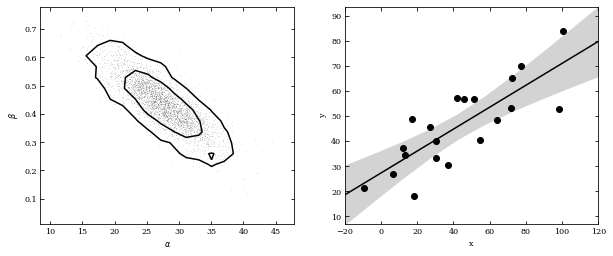

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import pymc3 as pm
import theano.tensor as tt

np.random.seed(42)
theta_true = (25, 0.5)
xdata = 100 * np.random.random(20)
ydata = theta_true[0] + theta_true[1] * xdata

# add scatter to points
xdata = np.random.normal(xdata, 10)
ydata = np.random.normal(ydata, 10)
data = {"x": xdata, "y": ydata}

# define loglikelihood outside of the model context, otherwise cores wont work:
# Lambdas defined in local namespace are not picklable (see issue #1995)
def loglike1(value):
    return -1.5 * tt.log(1 + value ** 2)


def loglike2(value):
    return -tt.log(tt.abs_(value))


with pm.Model() as model:
    alpha = pm.Normal("intercept", mu=0, sigma=100)
    # Create custom densities
    beta = pm.DensityDist("slope", loglike1, testval=0)
    sigma = pm.DensityDist("sigma", loglike2, testval=1)
    # Create likelihood
    like = pm.Normal("y_est", mu=alpha + beta * xdata, sigma=sigma, observed=ydata)

    trace = pm.sample(2000, cores=2)


#################################################
# Create some convenience routines for plotting
# All functions below written by Jake Vanderplas


def compute_sigma_level(trace1, trace2, nbins=20):
    """From a set of traces, bin by number of standard deviations"""
    L, xbins, ybins = np.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1e-16

    shape = L.shape
    L = L.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]

    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    return xbins, ybins, L_cumsum[i_unsort].reshape(shape)


def plot_MCMC_trace(ax, xdata, ydata, trace, scatter=False, **kwargs):
    """Plot traces and contours"""
    xbins, ybins, sigma = compute_sigma_level(trace[0], trace[1])
    ax.contour(xbins, ybins, sigma.T, levels=[0.683, 0.955], **kwargs)
    if scatter:
        ax.plot(trace[0], trace[1], ",k", alpha=0.1)
    ax.set_xlabel(r"$\alpha$")
    ax.set_ylabel(r"$\beta$")


def plot_MCMC_model(ax, xdata, ydata, trace):
    """Plot the linear model and 2sigma contours"""
    ax.plot(xdata, ydata, "ok")

    alpha, beta = trace[:2]
    xfit = np.linspace(-20, 120, 10)
    yfit = alpha[:, None] + beta[:, None] * xfit
    mu = yfit.mean(0)
    sig = 2 * yfit.std(0)

    ax.plot(xfit, mu, "-k")
    ax.fill_between(xfit, mu - sig, mu + sig, color="lightgray")

    ax.set_xlabel("x")
    ax.set_ylabel("y")


def plot_MCMC_results(xdata, ydata, trace, colors="k"):
    """Plot both the trace and the model together"""
    _, ax = plt.subplots(1, 2, figsize=(10, 4))
    plot_MCMC_trace(ax[0], xdata, ydata, trace, True, colors=colors)
    plot_MCMC_model(ax[1], xdata, ydata, trace)


pymc3_trace = [trace["intercept"], trace["slope"], trace["sigma"]]

plot_MCMC_results(xdata, ydata, pymc3_trace)
plt.show()

PyMC is far from the only option for MCMC computation in Python. One other
tool that deserves mention is emcee https://arxiv.org/abs/1202.3665  https://emcee.readthedocs.io/en/stable/ a package developed by astronomers, which implements a variant of MCMC where the sampling is invariant to affine transforms. Affine-invariant MCMC is a powerful algorithm and offers improved
runtimes for some common classes of problems.



Least-squares estimates:
m = -1.104 ± 0.016
b = 5.441 ± 0.091


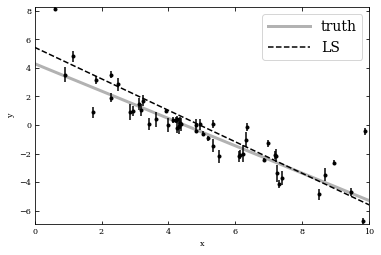

In [ ]:
np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Maximum likelihood estimates:
m = -1.003
b = 4.528
f = 0.454


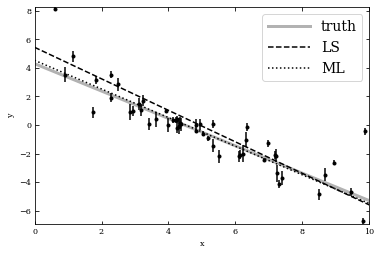

In [ ]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [ ]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:08<00:00, 606.55it/s]


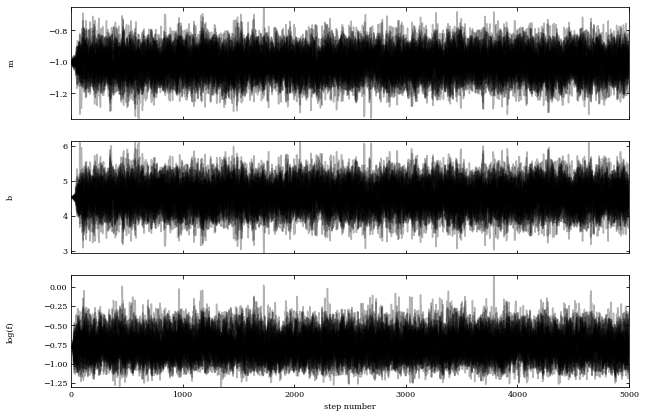

In [ ]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


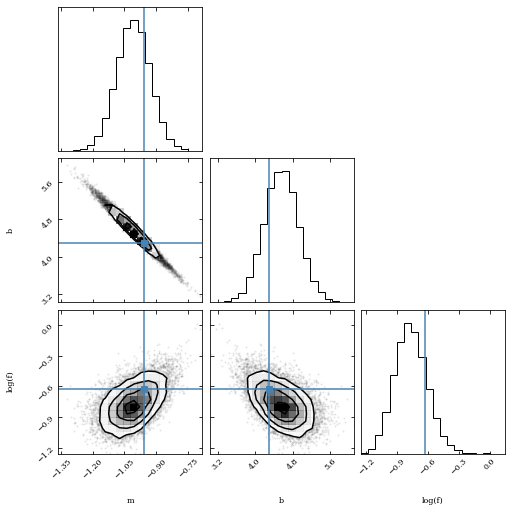

In [ ]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);

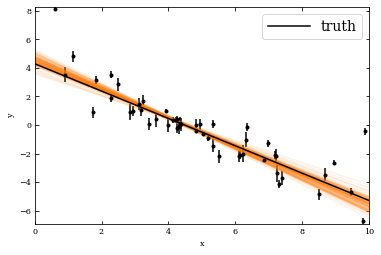

In [ ]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [ ]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

For cosmology applications cosmoMC is mostly used:
https://cosmologist.info/cosmomc/ see also https://arxiv.org/abs/1808.05080 for details.

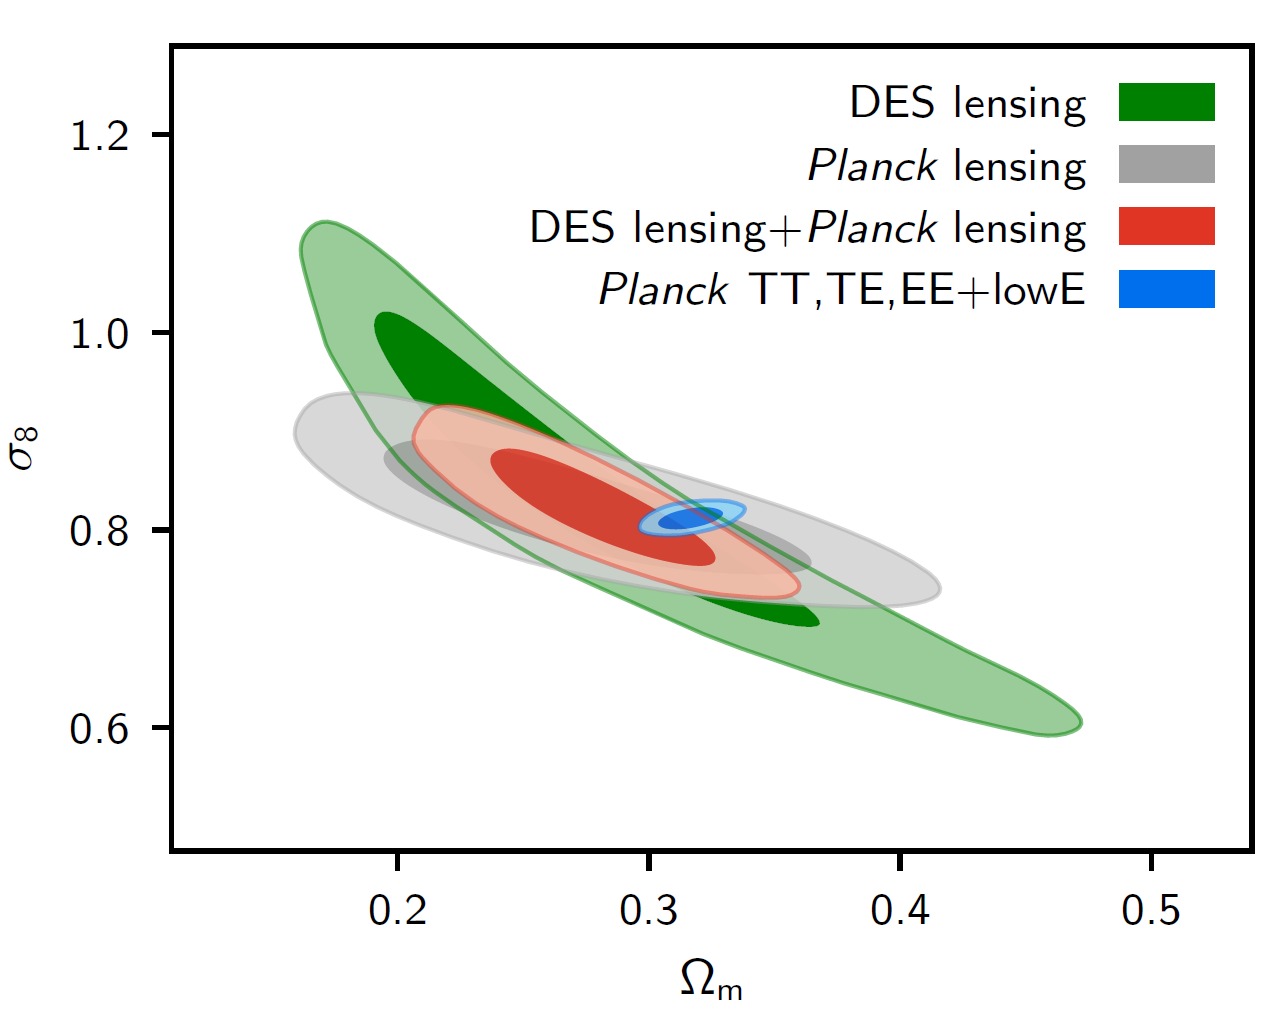

# Example: Model Selection with MCMC
Here we return to the problem of model selection from a Bayesian perspective. We
have previously mentioned the odds ratio, which takes into account the entire
posterior distribution, and the Aikake and Bayesian information criteria, which are based on normality assumptions of the posterior.

Here we will examine an example of distinguishing between unimodal and
bimodal models of a distribution in a Bayesian framework. Consider the data sample
shown next. The sample is drawn from a bimodal distribution: the sum
of two Gaussians, with the parameter values indicated in the figure. The best-fit
normal distribution is shown as a dashed line. The question is, can we use a Bayesian
framework to determine whether a single-peak or double-peak Gaussian is a better
fit to the data?

A double Gaussian model is a five-parameter model: the first four parameters
include the mean and width for each distribution, and the fifth parameter is the
elative normalization (weight) of the two components. Computing the AIC and BIC
for the two models is relatively straightforward:

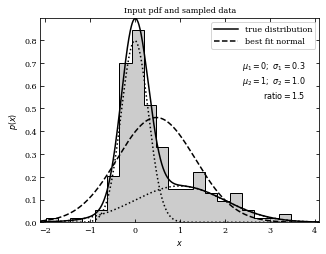

In [ ]:
"""
Histogram for Double-gaussian model test
----------------------------------------
Figure 5.23
A sample of 200 points drawn from a Gaussian mixture model used to illustrate
model selection with MCMC.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
from astroML.density_estimation import GaussianMixture1D

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Generate the data
mu1_in = 0
sigma1_in = 0.3
mu2_in = 1
sigma2_in = 1
ratio_in = 1.5
N = 200

np.random.seed(10)
gm = GaussianMixture1D([mu1_in, mu2_in],
                       [sigma1_in, sigma2_in],
                       [ratio_in, 1])
x_sample = gm.sample(N)[0]

#------------------------------------------------------------
# Get the MLE fit for a single gaussian
sample_mu = np.mean(x_sample)
sample_std = np.std(x_sample, ddof=1)

#------------------------------------------------------------
# Plot the sampled data
fig, ax = plt.subplots(figsize=(5, 3.75))

ax.hist(x_sample, 20, histtype='stepfilled', density=True, fc='#CCCCCC')
x = np.linspace(-2.1, 4.1, 1000)

factor1 = ratio_in / (1. + ratio_in)
factor2 = 1. / (1. + ratio_in)

ax.plot(x, gm.pdf(x), '-k', label='true distribution')
ax.plot(x, gm.pdf_individual(x), ':k')

ax.plot(x, norm.pdf(x, sample_mu, sample_std), '--k', label='best fit normal')

ax.legend(loc=1)

ax.set_xlim(-2.1, 4.1)

ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')
ax.set_title('Input pdf and sampled data')
ax.text(0.95, 0.80, ('$\mu_1 = 0;\ \sigma_1=0.3$\n'
                     '$\mu_2=1;\ \sigma_2=1.0$\n'
                     '$\mathrm{ratio}=1.5$'),
        transform=ax.transAxes, ha='right', va='top')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [M1_log_sigma, M1_mu]


Sampling 2 chains for 100 tune and 2_500 draw iterations (200 + 5_000 draws total) took 7 seconds.
The acceptance probability does not match the target. It is 0.9367188639798117, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.932147856140994, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ratio, M2_log_sigma2, M2_log_sigma1, M2_mu2, M2_mu1]


Sampling 2 chains for 100 tune and 2_500 draw iterations (200 + 5_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8883940520867107, but should be close to 0.8. Try to increase the number of tuning steps.
There were 603 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.35387596369832236, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


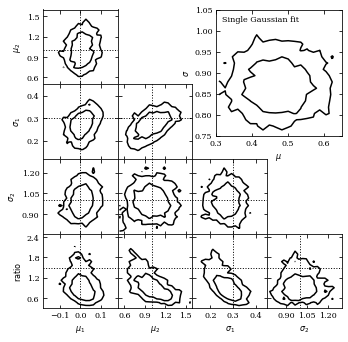

In [ ]:
"""
MCMC Model Comparison
---------------------
Figure 5.24
The top-right panel shows the posterior pdf for mu and sigma for a single
Gaussian fit to the data shown in figure 5.23. The remaining panels show the
projections of the five-dimensional pdf for a Gaussian mixture model with
two components. Contours are based on a 10,000 point MCMC chain.
"""
# Author: Jake VanderPlas (adapted to PyMC3 by Brigitta Sipocz)
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from scipy.special import gamma
from sklearn.neighbors import BallTree
import pymc3 as pm
import theano.tensor as tt

from astroML.density_estimation import GaussianMixture1D
from astroML.plotting import plot_mcmc

# ----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)


def estimate_bayes_factor(trace, r=0.05, return_list=False):
    """Estimate the bayes factor using the local density of points"""

    # Convert traces to a numpy array, ignore the intervals
    trace_arr = np.array([trace[i] for i in trace.varnames if "_interval__" not in i])
    trace_t = trace_arr.T
    N_iter, D = trace_t.shape

    # compute volume of a D-dimensional sphere of radius r
    Vr = np.pi ** (0.5 * D) / gamma(0.5 * D + 1) * (r ** D)

    # use neighbor count within r as a density estimator
    bt = BallTree(trace_t)
    count = bt.query_radius(trace_t, r=r, count_only=True)

    BF = trace.model_logp + np.log(N_iter) + np.log(Vr) - np.log(count)

    if return_list:
        return BF
    else:
        p25, p50, p75 = np.percentile(BF, [25, 50, 75])
        return p50, 0.7413 * (p75 - p25)


# ------------------------------------------------------------
# Generate the data
mu1_in = 0
sigma1_in = 0.3
mu2_in = 1
sigma2_in = 1
ratio_in = 1.5
N = 200

np.random.seed(10)
gm = GaussianMixture1D([mu1_in, mu2_in],
                       [sigma1_in, sigma2_in],
                       [ratio_in, 1])
x_sample = gm.sample(N)[0]


# ------------------------------------------------------------
# Set up pyMC3 model: single gaussian
#  2 parameters: (mu, sigma)
with pm.Model() as model1:
    M1_mu = pm.Uniform('M1_mu', -5, 5)
    M1_log_sigma = pm.Uniform('M1_log_sigma', -10, 10)

    M1 = pm.Normal('M1', mu=M1_mu, sd=np.exp(M1_log_sigma), observed=x_sample)
    trace1 = pm.sample(draws=2500, tune=100)


# ------------------------------------------------------------
# Set up pyMC3 model: mixture of two gaussians
#  5 parameters: (mu1, mu2, sigma1, sigma2, ratio)
with pm.Model() as model2:
    M2_mu1 = pm.Uniform('M2_mu1', -5, 5)
    M2_mu2 = pm.Uniform('M2_mu2', -5, 5)

    M2_log_sigma1 = pm.Uniform('M2_log_sigma1', -10, 10)
    M2_log_sigma2 = pm.Uniform('M2_log_sigma2', -10, 10)

    ratio = pm.Uniform('ratio', 1E-3, 1E3)

    w1 = ratio / (1 + ratio)
    w2 = 1 - w1

    y = pm.NormalMixture('doublegauss',
                         w=tt.stack([w1, w2]),
                         mu=tt.stack([M2_mu1, M2_mu2]),
                         sd=tt.stack([np.exp(M2_log_sigma1),
                                      np.exp(M2_log_sigma2)]),
                         observed=x_sample)

    trace2 = pm.sample(draws=2500, tune=100)


# ------------------------------------------------------------
# Compute Odds ratio with density estimation technique

BF1, dBF1 = estimate_bayes_factor(trace1, r=0.05)
BF2, dBF2 = estimate_bayes_factor(trace2, r=0.05)

# ------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 5))

labels = [r'$\mu_1$',
          r'$\mu_2$',
          r'$\sigma_1$',
          r'$\sigma_2$',
          r'${\rm ratio}$']

true_values = [mu1_in,
               mu2_in,
               sigma1_in,
               sigma2_in,
               ratio_in]

limits = [(-0.18, 0.18),
          (0.5, 1.6),
          (0.12, 0.45),
          (0.76, 1.3),
          (0.3, 2.5)]

# We assume mu1 < mu2, but the results may be switched
# due to the symmetry of the problem.  If so, switch back
if np.median(trace2['M2_mu1']) < np.median(trace2['M2_mu2']):
    trace2_for_plot = [np.exp(trace2[i]) if 'log_sigma' in i else trace2[i] for i in
                       ['M2_mu1', 'M2_mu2', 'M2_log_sigma1', 'M2_log_sigma2', 'ratio']]
else:
    trace2_for_plot = [np.exp(trace2[i]) if 'log_sigma' in i else trace2[i] for i in
                       ['M2_mu2', 'M2_mu1', 'M2_log_sigma2', 'M2_log_sigma1', 'ratio']]

# Plot the simple 2-component model
ax, = plot_mcmc([trace1['M1_mu'], np.exp(trace1['M1_log_sigma'])],
                fig=fig, bounds=[0.6, 0.6, 0.95, 0.95],
                limits=[(0.3, 0.65), (0.75, 1.05)],
                labels=[r'$\mu$', r'$\sigma$'], colors='k')

ax.text(0.05, 0.95, "Single Gaussian fit", va='top', ha='left',
        transform=ax.transAxes)

# Plot the 5-component model
ax_list = plot_mcmc(trace2_for_plot, limits=limits, labels=labels,
                    true_values=true_values, fig=fig,
                    bounds=(0.12, 0.12, 0.95, 0.95),
                    colors='k')
for ax in ax_list:
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_locator(plt.MaxNLocator(4))

plt.show()

It is clear that by all three measures, the double Gaussian model is preferred.
But these measures are only accurate if the posterior distribution is approximately
Gaussian. For non-Gaussian posteriors, the best statistic to use is the odds ratio. While odds ratios involving two-dimensional posteriors can be computed relatively easily, integrating five-dimensional posteriors is computationally
difficult. This is one manifestation of the curse of dimensionality. So how
do we proceed? One way to estimate an odds ratio is based on MCMC sampling.

In [ ]:
!pip install astroML

In [ ]:
!pip install emcee

In [ ]:
!pip install corner